In [3]:
#!pip install seaborn
#!pip install torch
#!pip install pyarrow

In [4]:
import warnings
warnings.filterwarnings("ignore")

import os
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import learning_curve

### Data clean-up

In [5]:
pickle_file_path = "patient_concatenated_df.pkl"

# Check if the pickle file exists
if os.path.exists(pickle_file_path):
    patient_concatenated_df = pd.read_pickle(pickle_file_path)

    display("patient_concatenated_df")
    display(patient_concatenated_df.head())
    display(patient_concatenated_df.shape)

    print("DataFrame loaded successfully!")

else:
    print("Pickle file does not exist.")

    train_df = pd.read_csv('train.csv')
    display("train.csv df")
    display(train_df.head())
    display(train_df.shape)

    unique_rows_df = train_df.drop_duplicates(subset=['eeg_id', 'spectrogram_id', 'patient_id', 'expert_consensus'])

    # Shuffle the rows of the DataFrame
    unique_rows_df = unique_rows_df.sample(frac=1).reset_index(drop=True)
    print("After drop duplicate...")
    display(unique_rows_df.head())
    display(unique_rows_df.shape)

    EEG_PATH = 'train_eegs/'
    SPEC_PATH = 'train_spectrograms/'
    patient_concatenated_df = pd.DataFrame()
    patient_count=0

    # Iterate over each row in the DataFrame
    for index, row in unique_rows_df.iterrows():

        #print(row)
        #print("---------------")
        expert_consensus_value = row['expert_consensus']
        #print("expert_consensus:", expert_consensus_value)
        #print("eeg_id:", row['eeg_id'])
        #print("patient_id:", row['patient_id'])
        #print("spectrogram_id:", row['spectrogram_id'])

        eeg = pd.read_parquet(f'{EEG_PATH}{row.eeg_id}.parquet')

        #print("using row.eeg_id:", row.eeg_id)
        #print(f'{EEG_PATH}{row.eeg_id}.parquet')
        #display(eeg.head())
        #print(eeg.shape)
        #print("---------------")

        eeg_offset = int( row.eeg_label_offset_seconds )
        eeg = eeg.iloc[eeg_offset*200:(eeg_offset+50)*200]

        #print("using row.eeg_id:", row.eeg_id)
        #print(f'{EEG_PATH}{row.eeg_id}.parquet')
        #display(eeg.head())
        #print(eeg.shape)
        #print("---------------")

        spectrogram = pd.read_parquet(f'{SPEC_PATH}{row.spectrogram_id}.parquet')

        #print("row.spectrogram_id:", row.spectrogram_id)
        #print(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
        #display(spectrogram.head())
        #print(spectrogram.shape)
        #print("---------------")

        spec_offset = int( row.spectrogram_label_offset_seconds )
        spectrogram = spectrogram.loc[(spectrogram.time>=spec_offset)
                             &(spectrogram.time<spec_offset+600)]

        #print("row.spectrogram_id", row.spectrogram_id)
        #print(f'{SPEC_PATH}{row.spectrogram_id}.parquet')
        #display(spectrogram.head())
        #print(spectrogram.shape)

        #headers_list = spectrogram.columns.tolist()
        #print(headers_list)

        combined_df = pd.concat([spectrogram, eeg], axis=0)
        combined_df.reset_index(drop=True, inplace=True)
        df_filled = combined_df.fillna(combined_df.mean())
        #display(df_filled.head())
        #display(df_filled.shape)

        df_filled['label'] = expert_consensus_value
        #display(df_filled)

        # Concatenate the current result with the overall DataFrame
        patient_concatenated_df = pd.concat([patient_concatenated_df, df_filled], axis=0)

        #print("*"*10)
        patient_count= patient_count+1
        if patient_count == 500:
            print("patient_count:", patient_count)
            break

    patient_concatenated_df.reset_index(drop=True, inplace=True)

    display("patient_concatenated_df")
    display(patient_concatenated_df.head())
    display(patient_concatenated_df.shape)

    #for a faster testing with only 10% of data when needed
    patient_concatenated_df_shuffled = patient_concatenated_df.sample(frac=1, random_state=42)  # random_state for reproducibility
    patient_ten_percent_df = patient_concatenated_df_shuffled.sample(frac=0.05, random_state=42)  # random_state for reproducibility

    display("patient_ten_percent_df")
    display(patient_ten_percent_df.head())
    display(patient_ten_percent_df.shape)

    patient_concatenated_df.to_pickle('patient_concatenated_df.pkl')
    patient_ten_percent_df.to_pickle('patient_ten_percent_df.pkl')

Pickle file does not exist.


'train.csv df'

,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,1628180742,0,0.0,353733,0,0.0,127492639,42516,Seizure,3,0,0,0,0,0
1,1628180742,1,6.0,353733,1,6.0,3887563113,42516,Seizure,3,0,0,0,0,0
2,1628180742,2,8.0,353733,2,8.0,1142670488,42516,Seizure,3,0,0,0,0,0
3,1628180742,3,18.0,353733,3,18.0,2718991173,42516,Seizure,3,0,0,0,0,0
4,1628180742,4,24.0,353733,4,24.0,3080632009,42516,Seizure,3,0,0,0,0,0


(106800, 15)

After drop duplicate...


,eeg_id,eeg_sub_id,eeg_label_offset_seconds,spectrogram_id,spectrogram_sub_id,spectrogram_label_offset_seconds,label_id,patient_id,expert_consensus,seizure_vote,lpd_vote,gpd_vote,lrda_vote,grda_vote,other_vote
0,2755824662,0,0.0,976221295,15,1896.0,1971442820,55705,Other,0,0,0,0,0,2
1,3328238125,0,0.0,1108200131,0,0.0,3358115169,61621,GPD,0,0,7,0,6,2
2,72214631,0,0.0,1068576668,0,0.0,1394403407,58220,Other,0,0,0,0,3,12
3,3385366163,0,0.0,2075533226,5,376.0,2605662618,10918,Seizure,3,0,0,0,0,0
4,1436583350,0,0.0,964007229,0,0.0,1650647665,34153,GPD,0,0,2,0,0,2


(18013, 15)

patient_count: 500


'patient_concatenated_df'

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG,label
0,1897.0,45.529999,48.669998,73.529999,71.129997,55.919998,48.669998,28.280001,14.04,7.26,...,-0.330317,-0.220893,-0.169973,-0.717621,-1.385825,-1.557639,-0.638389,-2.110389,1.133554,Other
1,1899.0,29.110001,36.349998,34.919998,25.059999,17.910000,7.730000,11.880000,7.29,8.29,...,-0.330317,-0.220893,-0.169973,-0.717621,-1.385825,-1.557639,-0.638389,-2.110389,1.133554,Other
2,1901.0,17.410000,25.370001,18.980000,12.700000,11.220000,7.310000,5.170000,5.58,3.99,...,-0.330317,-0.220893,-0.169973,-0.717621,-1.385825,-1.557639,-0.638389,-2.110389,1.133554,Other
3,1903.0,29.480000,34.770000,30.150000,22.750000,17.379999,9.550000,7.860000,6.16,3.99,...,-0.330317,-0.220893,-0.169973,-0.717621,-1.385825,-1.557639,-0.638389,-2.110389,1.133554,Other
4,1905.0,57.430000,66.690002,67.750000,34.189999,26.940001,15.680000,13.760000,11.82,11.18,...,-0.330317,-0.220893,-0.169973,-0.717621,-1.385825,-1.557639,-0.638389,-2.110389,1.133554,Other


(5150000, 422)

'patient_ten_percent_df'

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG,label
217983,304.0,6.856900,8.233334,8.461134,6.875867,5.040433,3.762667,3.097733,2.626000,2.192133,...,-57.419998,329.640015,-13.820000,14.360000,-39.080002,-36.150002,-34.820000,-0.800000,6.110000,GPD
256016,300.0,479.353241,537.761108,499.212799,344.268768,221.382294,152.045700,111.234207,88.795906,76.981270,...,63.549999,31.090000,13.660000,40.110001,94.279999,47.360001,47.950001,58.119999,155.520004,Other
4423228,632.0,1.505267,1.791000,1.846567,1.535133,1.196533,0.985500,0.853267,0.743300,0.629733,...,-26.580000,-49.450001,-55.029999,-19.940001,-32.169998,-34.820000,-30.840000,704.739990,-1.600000,Other
3045274,300.0,18.195667,21.894566,21.914333,16.896101,11.222500,7.308800,5.181600,3.986300,3.200500,...,-2.350000,9.430000,-22.750000,-32.540001,-193.009995,-24.360001,-27.719999,-14.370000,-25.830000,Other
2238890,822.0,109.396858,130.140518,133.284027,106.127998,84.907669,70.616501,60.738300,53.279968,46.254700,...,-20.100000,19.559999,6.820000,-10.160000,-96.620003,-17.570000,-23.299999,16.959999,42.630001,Other


(257500, 422)

In [6]:
patient_concatenated_df = patient_ten_percent_df # monitoring results - taking lower time to run

### Data Split

In [7]:
label_column = 'label'
y = patient_concatenated_df['label']
X = patient_concatenated_df
X = X.drop(columns=[label_column])

# Encoding labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("X_train.shape:", X_train.shape)
print("X_test.shape:", X_test.shape)
print("y_train.shape:", y_train.shape)
print("y_test.shape:", y_test.shape)

X_train.shape: (206000, 421)
X_test.shape: (51500, 421)
y_train.shape: (206000,)
y_test.shape: (51500,)


In [8]:
display(X_train)
display(y_train)

,time,LL_0.59,LL_0.78,LL_0.98,LL_1.17,LL_1.37,LL_1.56,LL_1.76,LL_1.95,LL_2.15,...,Pz,Fp2,F4,C4,P4,F8,T4,T6,O2,EKG
4837354,300.0,39.864670,56.632130,70.660896,72.936165,67.404762,56.816174,43.188931,33.570332,29.341833,...,-37.480000,-101.019997,-84.800003,-44.130001,-36.419998,-47.590000,8.240000,-30.840000,-18.340000,4.250000
325732,1658.0,526.076416,671.364441,705.203430,646.711121,510.779633,403.698853,337.506378,283.877930,222.398209,...,21.809999,13.780000,31.010000,3.460000,-5.070000,-18.139999,-12.260000,-30.139999,-4.460000,-3.050000
3654830,1464.0,17.312065,19.835066,19.885767,15.703266,10.801400,8.268433,7.069300,7.176466,7.079067,...,-83.019997,-59.720001,-82.129997,-85.029999,-96.059998,-113.230003,-82.970001,-41.439999,-63.759998,-5.340000
85503,300.0,106175.468750,117567.984375,110344.382812,84461.570312,58064.933594,43580.253906,34028.156250,27582.550781,21895.017578,...,-17.809999,-2339.909912,-114.309998,-65.930000,-93.580002,-2084.179932,-143.289993,-149.669998,-81.879997,-36.419998
4861194,300.0,2001.818726,2079.449463,1899.997925,1153.495850,725.237793,513.481323,395.494263,298.359070,254.825592,...,502.600006,-121.339996,698.270020,568.619995,506.279999,42.570000,869.830017,486.660004,670.919983,592.750000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4056524,300.0,38.653236,42.366001,36.859200,24.144434,17.376266,12.226733,9.543900,9.258867,8.226633,...,-134.509995,32.430000,1.060000,7.440000,3.460000,20.469999,13.030000,26.580000,-31.100000,26.320000
261086,300.0,319.009552,414.004852,463.054688,434.915771,373.754211,318.818756,288.442505,269.872986,240.334534,...,32.840000,96.339996,39.889999,41.689999,52.310001,65.029999,40.619999,76.010002,42.529999,45.160000
928299,300.0,599.295410,617.355713,497.344543,284.241058,127.099678,54.397396,24.249399,11.073233,6.568633,...,20.420000,-5.050000,5.370000,24.170000,25.530001,9.350000,-6.660000,-3.150000,4.330000,-169.050003
2377667,300.0,8.853066,10.172366,10.284834,7.978067,5.465999,3.864967,2.733267,1.933833,1.439800,...,-15.390000,13.130000,-0.900000,-10.480000,-28.540001,12.710000,10.240000,-13.800000,-0.110000,-273.049988


array([5, 2, 5, ..., 4, 1, 4])

### Data exploration

#### RandomForest Dim. Reduction

In [9]:
param_grid = {
    'threshold': ['mean', 'median', 0.00005, 0.0001],  # Adjust threshold values
    'estimator__n_estimators': [100, 200, 300],  # RandomForestClassifier parameters
    'estimator__max_depth': [1, 10, 20],
    'estimator__min_samples_split': [2, 5, 10]
}

# Initialize RandomForestClassifier
base_model = RandomForestClassifier()

# Initialize SelectFromModel with the base model
selector = SelectFromModel(base_model)

# Include 'estimator__' prefix to specify parameters for RandomForestClassifier
grid_search = GridSearchCV(estimator=selector, param_grid=param_grid, cv=5, scoring='accuracy')

# Fit the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

# Get the best model
best_selector = grid_search.best_estimator_

# Transform the data to include only the selected features
X_train_selected = best_selector.transform(X_train)

# Get the indices of the selected features
selected_indices = best_selector.get_support(indices=True)

# Get the names of selected features
selected_feature_names = X_train.columns[selected_indices]
print(selected_feature_names)
print(len(selected_feature_names))

X_train = X_train[selected_feature_names]
X_test = X_test[selected_feature_names]

display(len(X_train.columns))
display(X_train.head())


Best Hyperparameters: {'estimator__max_depth': 1, 'estimator__min_samples_split': 2, 'estimator__n_estimators': 100, 'threshold': 'mean'}
Index(['LL_2.15', 'LL_2.34', 'LL_2.54', 'LL_2.73', 'LL_2.93', 'LL_3.13',
       'LL_3.32', 'LL_3.52', 'LL_3.71', 'LL_3.91', 'LL_4.1', 'LL_4.3',
       'LL_4.49', 'LL_4.69', 'LL_4.88', 'LL_5.08', 'LL_5.86', 'LL_6.05',
       'LL_6.45', 'LL_6.64', 'LL_7.03', 'LL_7.42', 'LL_7.81', 'LL_8.2',
       'RL_9.57', 'LP_4.3', 'LP_5.08', 'LP_5.47', 'LP_6.45', 'LP_6.64',
       'LP_7.03', 'LP_7.42', 'LP_7.62', 'LP_18.75', 'RP_3.71', 'RP_6.45',
       'RP_6.64', 'RP_6.84', 'RP_10.55'],
      dtype='object')
39


39

,LL_2.15,LL_2.34,LL_2.54,LL_2.73,LL_2.93,LL_3.13,LL_3.32,LL_3.52,LL_3.71,LL_3.91,...,LP_6.64,LP_7.03,LP_7.42,LP_7.62,LP_18.75,RP_3.71,RP_6.45,RP_6.64,RP_6.84,RP_10.55
4837354,29.341833,27.641768,25.861633,22.828268,20.125332,17.363932,15.081800,13.894268,13.466634,12.497967,...,2.687033,2.553833,2.378567,2.290400,0.742800,5.499633,1.617100,1.521933,1.532233,1.005967
325732,222.398209,173.150909,126.853828,89.473869,67.605927,55.062702,45.584171,37.522633,31.758265,27.095732,...,3.944200,3.096300,2.560700,2.432067,0.312500,8.437134,3.889333,3.402933,3.032667,0.916433
3654830,7.079067,6.219767,5.948633,4.579567,3.415300,2.950333,2.400733,2.019800,1.732900,1.800567,...,1.726767,2.109200,2.407033,2.391433,0.286800,2.585733,2.120167,2.261333,2.413667,2.728566
85503,21895.017578,16911.767578,12296.368164,8960.898438,7009.043457,6044.015625,5804.663574,5565.936523,5127.659668,4370.336426,...,1903.201050,1723.481201,1570.955566,1458.427612,898.514404,17267.078125,2657.994873,2399.969238,2585.951172,1666.820679
4861194,254.825592,217.111664,175.685028,149.036835,125.326210,102.370132,88.021301,75.661560,63.338036,56.287636,...,13.132767,12.724766,12.070701,11.166201,3.235934,3391.387451,1333.154785,1538.967651,1667.296753,646.586121


Test Accuracy: 0.38


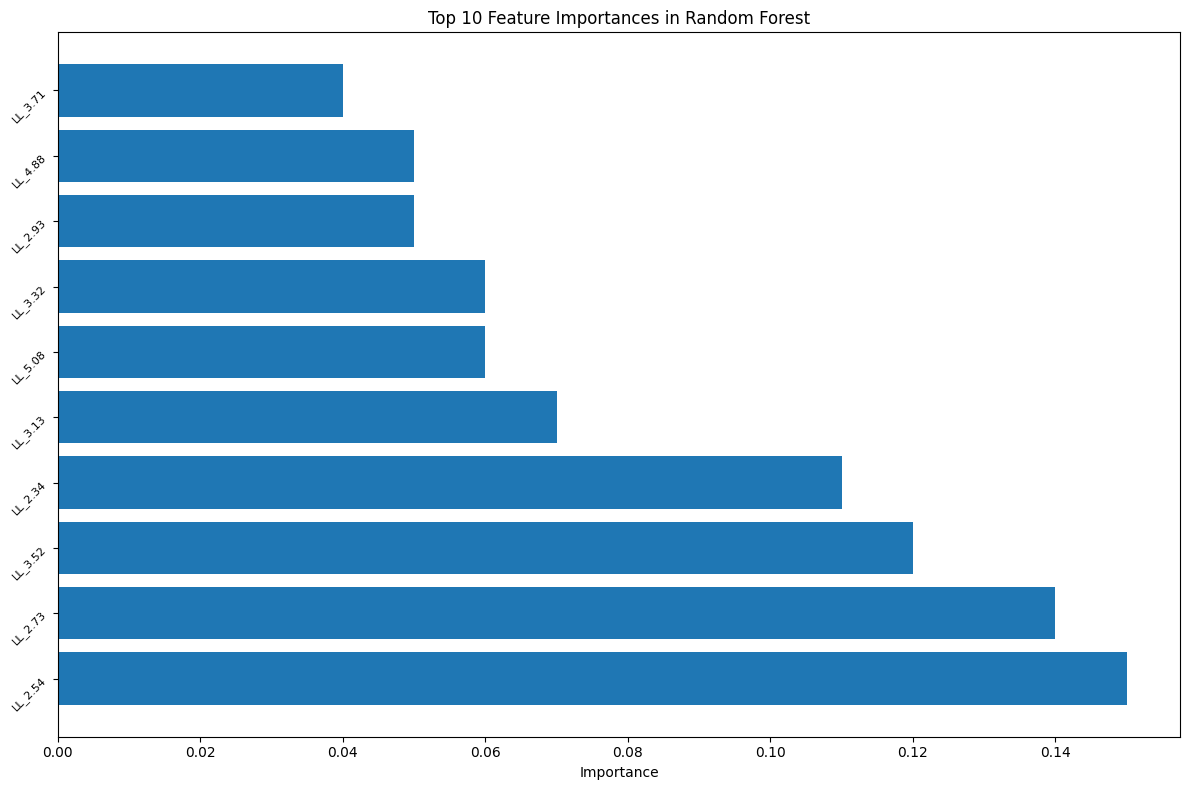

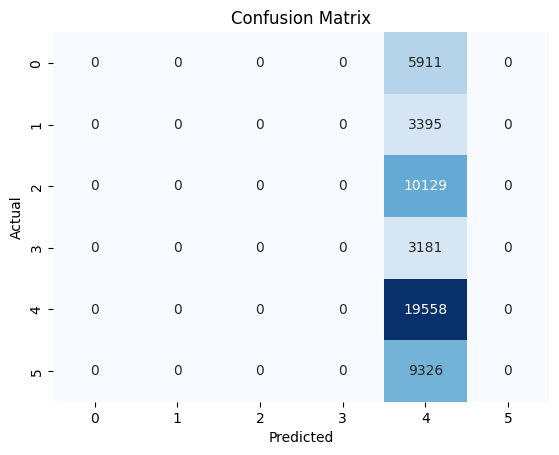

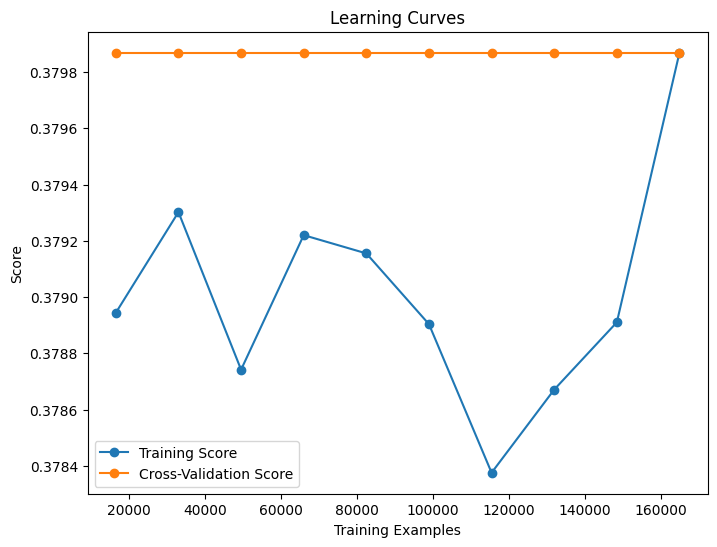

In [10]:
best_rf = best_selector.estimator_
best_rf.fit(X_train, y_train)

# Predict on the test set
y_pred = best_rf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {accuracy:.2f}")

feature_importances = best_rf.feature_importances_
indices = np.argsort(feature_importances)[::-1]  # Sort features by importance

# Set the number of features to display (e.g., top 10 most important)
num_top_features = 10
top_indices = indices[:num_top_features]

# Get the names of the sorted features
selected_feature_names_sorted = [selected_feature_names[i] for i in top_indices]

# Plot feature importances with larger figure size, rotated labels, and reduced font size
plt.figure(figsize=(12, 8))  # Increase figure size to give more room for labels
plt.title("Top 10 Feature Importances in Random Forest")
plt.barh(range(num_top_features), feature_importances[top_indices], align='center')

# Rotate labels for better visibility and reduce font size
plt.yticks(range(num_top_features), selected_feature_names_sorted, rotation=45, fontsize=8)  # Rotate labels
plt.xlabel('Importance')

plt.tight_layout()  # Ensure proper spacing to avoid clipping
plt.show()

# Plotting confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Plotting learning curves to visualize model learning over time
train_sizes, train_scores, test_scores = learning_curve(
    best_rf, X_train, y_train, cv=5, scoring='accuracy', train_sizes=np.linspace(0.1, 1.0, 10)
)

train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(8, 6))
plt.plot(train_sizes, train_scores_mean, 'o-', label="Training Score")
plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-Validation Score")
plt.title("Learning Curves")
plt.xlabel("Training Examples")
plt.ylabel("Score")
plt.legend(loc="best")
plt.show()

#### PCA (After RandomForest)

In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

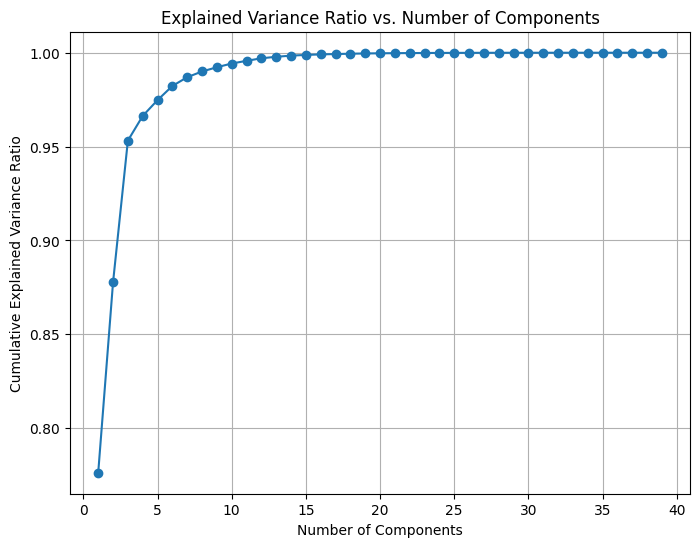

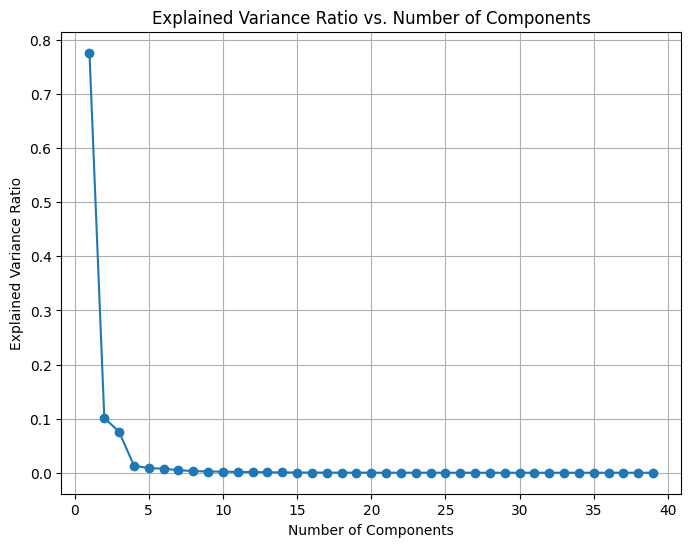

In [12]:
# Fit PCA and compute explained variance
pca = PCA()
pca.fit(X_train_scaled)

# Plot explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(8, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

# Elbow method
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [13]:
n_components = 15
pca = PCA(n_components=n_components)

X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

display(X_test_pca.shape)
display(X_train_pca.shape)

(51500, 15)

(206000, 15)

In [14]:
# Convert the NumPy array X_train_pca to a DataFrame
X_train_pca = pd.DataFrame(X_train_pca)
X_test_pca = pd.DataFrame(X_test_pca)

#### correlation

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
0,1.000000e+00,-1.453991e-07,3.075043e-07,9.797600e-09,1.308544e-07,7.695257e-07,-1.541894e-07,-2.959227e-07,4.039071e-08,4.923532e-07,3.907581e-08,-1.982250e-07,2.727386e-07,1.422649e-07,-2.029662e-09
1,-1.453991e-07,1.000000e+00,6.278190e-08,1.171874e-07,-5.822904e-08,-2.135405e-07,-2.717263e-08,3.156824e-07,-1.958531e-07,-6.100608e-08,-1.413392e-07,-4.099569e-08,3.290274e-07,-9.907905e-08,-1.360834e-07
2,3.075043e-07,6.278190e-08,1.000000e+00,-4.606224e-08,5.730944e-08,4.890072e-07,1.293261e-07,-2.350641e-07,1.373851e-07,-8.633881e-08,4.975288e-08,2.330548e-07,-3.176337e-07,1.401785e-07,2.593865e-07
3,9.797600e-09,1.171874e-07,-4.606224e-08,1.000000e+00,-8.851695e-08,-1.479224e-07,2.070806e-07,-1.914288e-07,-9.950632e-07,4.433405e-07,-2.176943e-07,3.899788e-07,2.669573e-07,-3.715853e-07,-3.649883e-07
4,1.308544e-07,-5.822904e-08,5.730944e-08,-8.851695e-08,1.000000e+00,-2.548935e-07,-1.010866e-07,-2.323131e-07,-8.959329e-08,9.756594e-08,-2.765924e-07,9.910865e-08,1.133986e-07,-7.803907e-08,-1.053258e-07
5,7.695257e-07,-2.135405e-07,4.890072e-07,-1.479224e-07,-2.548935e-07,1.000000e+00,3.051907e-07,2.010011e-07,-1.214007e-06,1.167470e-06,-1.425545e-07,9.495021e-07,9.392652e-07,3.585040e-07,-6.741098e-07
6,-1.541894e-07,-2.717263e-08,1.293261e-07,2.070806e-07,-1.010866e-07,3.051907e-07,1.000000e+00,4.854439e-07,-5.582791e-08,3.710861e-07,3.669073e-07,-8.283138e-07,-2.257950e-07,-3.411254e-08,-2.325690e-07
7,-2.959227e-07,3.156824e-07,-2.350641e-07,-1.914288e-07,-2.323131e-07,2.010011e-07,4.854439e-07,1.000000e+00,-9.201384e-07,1.683902e-07,1.198150e-07,1.037967e-06,-1.861020e-07,-5.368618e-07,1.566028e-07
8,4.039071e-08,-1.958531e-07,1.373851e-07,-9.950632e-07,-8.959329e-08,-1.214007e-06,-5.582791e-08,-9.201384e-07,1.000000e+00,-2.275006e-06,7.149980e-07,-1.994179e-07,-2.846035e-08,5.995914e-07,7.684870e-07
9,4.923532e-07,-6.100608e-08,-8.633881e-08,4.433405e-07,9.756594e-08,1.167470e-06,3.710861e-07,1.683902e-07,-2.275006e-06,1.000000e+00,-3.615285e-08,1.436977e-06,7.958289e-07,5.558333e-07,-8.745718e-07


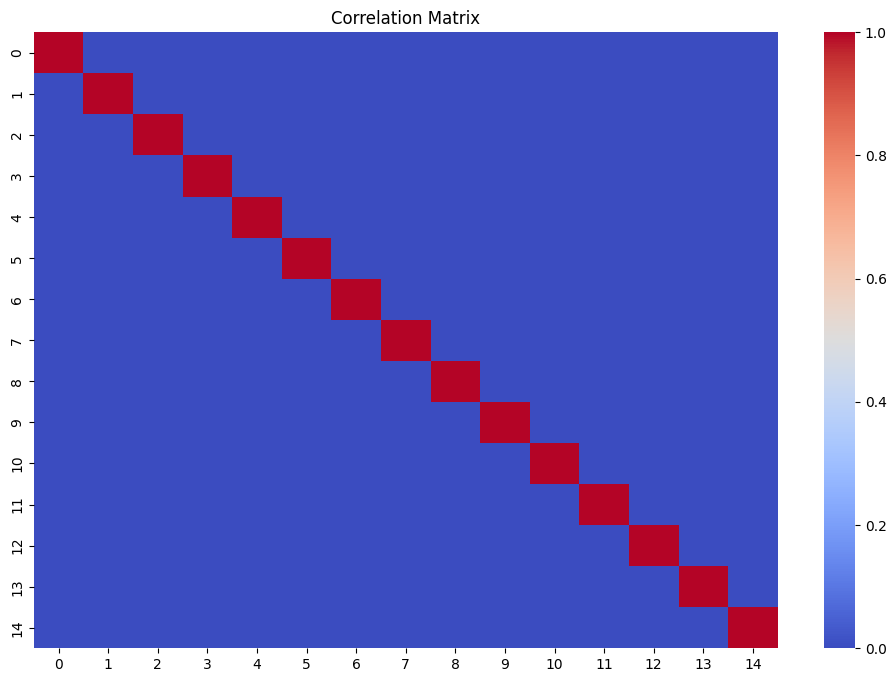

In [15]:
# Compute correlation matrix
corr_matrix = X_train_pca.corr()

display(corr_matrix)

# Plot heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

#### df.describe() pairplot

In [16]:
display(X_train_pca.describe())

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14
count,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05,2.060000e+05
mean,-5.762785e-08,-1.514768e-08,4.073949e-09,6.092405e-09,5.833153e-10,-1.941607e-08,5.249838e-08,3.529521e-08,-1.510370e-08,-2.351779e-09,1.294405e-08,-3.632990e-08,-4.741521e-08,9.610815e-09,2.633715e-08
std,5.502398e+00,1.988392e+00,1.715898e+00,7.160417e-01,5.734082e-01,5.419169e-01,4.267848e-01,3.449214e-01,2.959043e-01,2.793820e-01,2.351151e-01,2.306531e-01,1.761228e-01,1.546999e-01,1.218142e-01
min,-8.688234e-01,-1.733485e+02,-2.255961e+02,-7.045728e+01,-3.076475e+01,-5.219772e+01,-4.960970e+01,-4.254937e+01,-2.483118e+01,-2.915529e+01,-2.435805e+01,-2.487960e+01,-2.222882e+01,-1.582595e+01,-1.573052e+01
25%,-8.684032e-01,-1.306623e-01,2.533601e-03,1.382576e-02,-5.474251e-03,1.889536e-02,-2.211321e-02,9.392050e-03,-3.047487e-03,1.300322e-02,-6.927652e-03,-3.384001e-03,6.848088e-03,8.585300e-03,-2.845721e-03
50%,-8.678511e-01,-1.305172e-01,2.595632e-03,1.391230e-02,-5.132145e-03,1.893559e-02,-2.204274e-02,9.472582e-03,-2.976259e-03,1.306271e-02,-6.890181e-03,-3.361006e-03,6.935464e-03,8.695542e-03,-2.805239e-03
75%,-8.648587e-01,-1.303125e-01,2.735042e-03,1.398817e-02,-5.038864e-03,1.902697e-02,-2.167117e-02,9.545295e-03,-2.928172e-03,1.309344e-02,-6.802342e-03,-3.237267e-03,6.958241e-03,8.720541e-03,-2.783411e-03
max,5.082482e+02,2.768722e+02,2.783884e+02,2.516711e+02,7.362552e+01,1.717750e+02,1.102003e+02,8.417638e+01,5.067193e+01,7.512020e+01,5.426504e+01,2.829593e+01,3.366476e+01,1.714719e+01,2.251099e+01


### Outliers

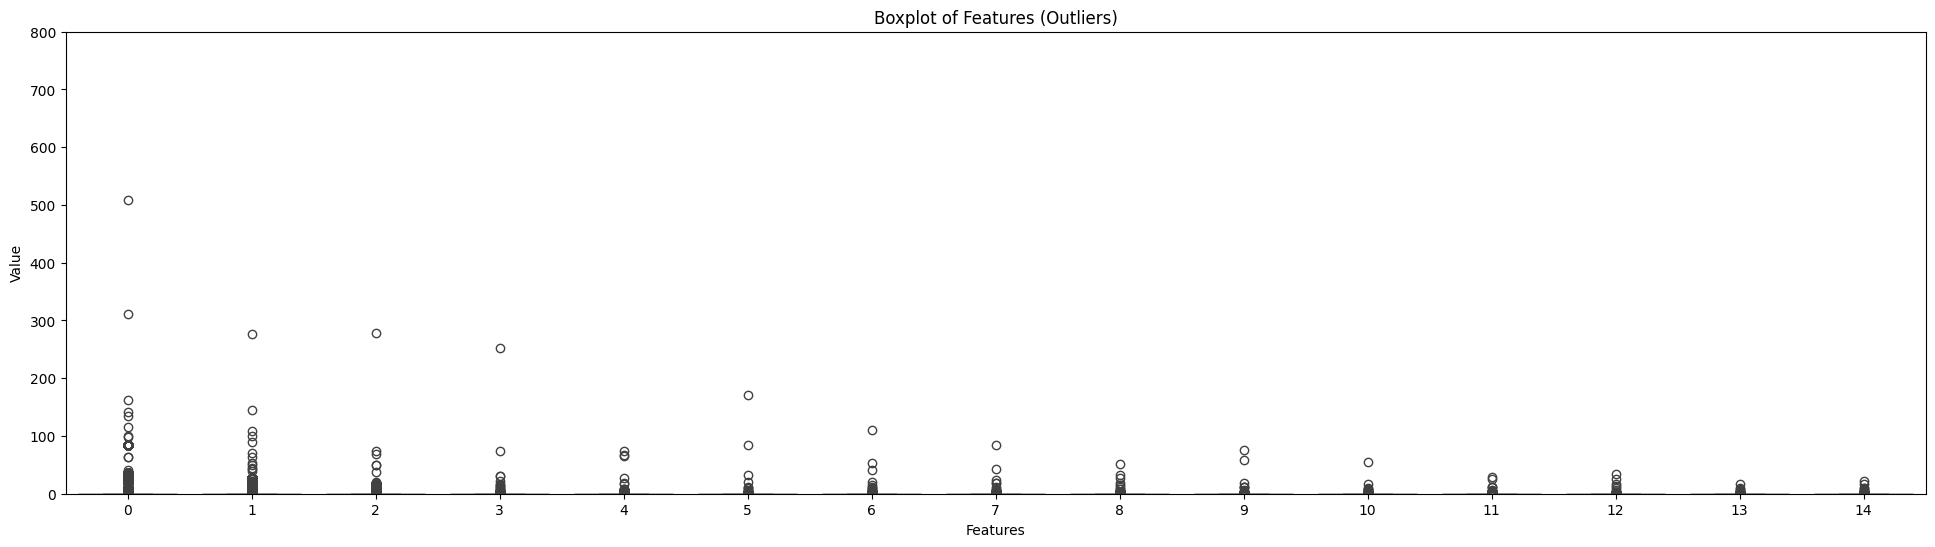

In [17]:
plt.figure(figsize=(24, 6))
sns.boxplot(data=X_train_pca, orient="v")
plt.ylim(0, 800)
plt.title('Boxplot of Features (Outliers)')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

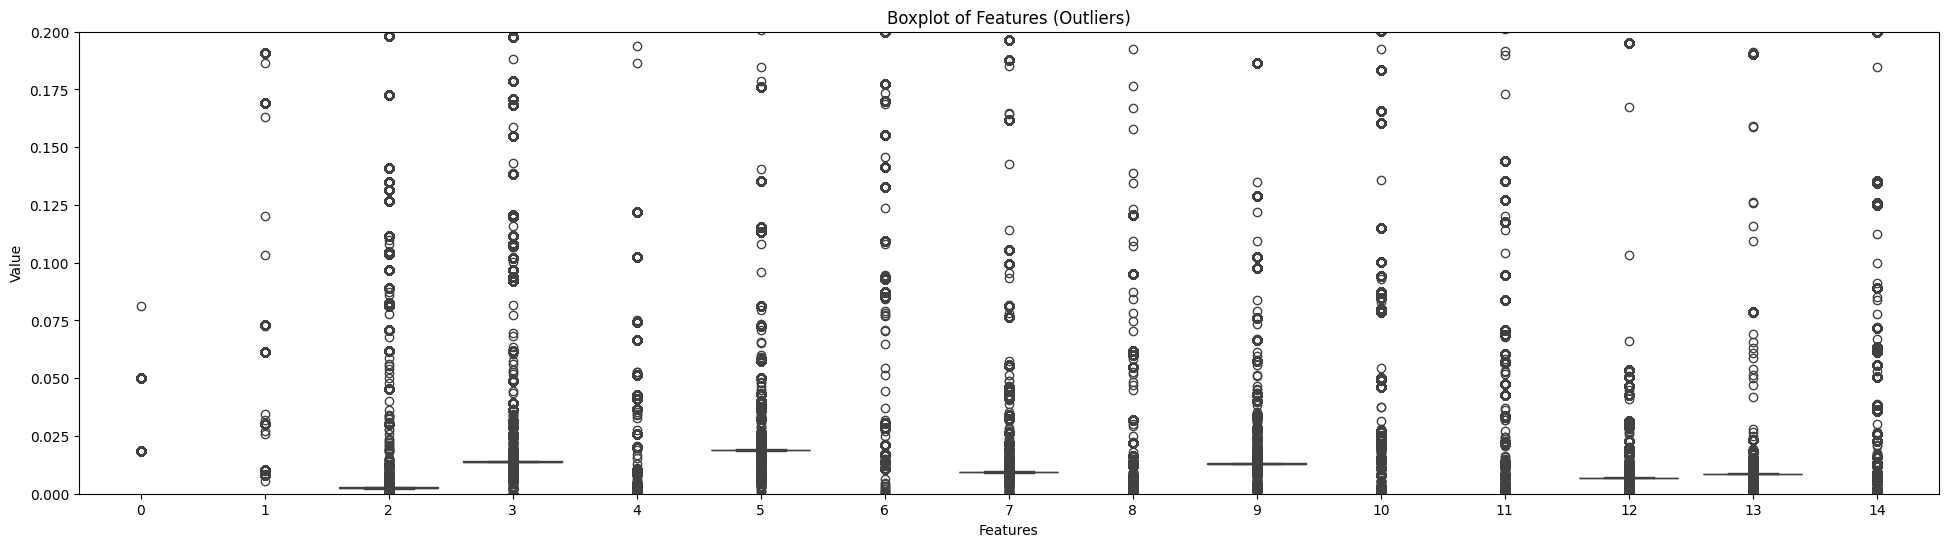

In [22]:
plt.figure(figsize=(24, 6))
sns.boxplot(data=X_train_pca, orient="v")
plt.ylim(0, 0.2)
plt.title('Boxplot of Features (Outliers)')
plt.xlabel('Features')
plt.ylabel('Value')
plt.show()

#### Variance

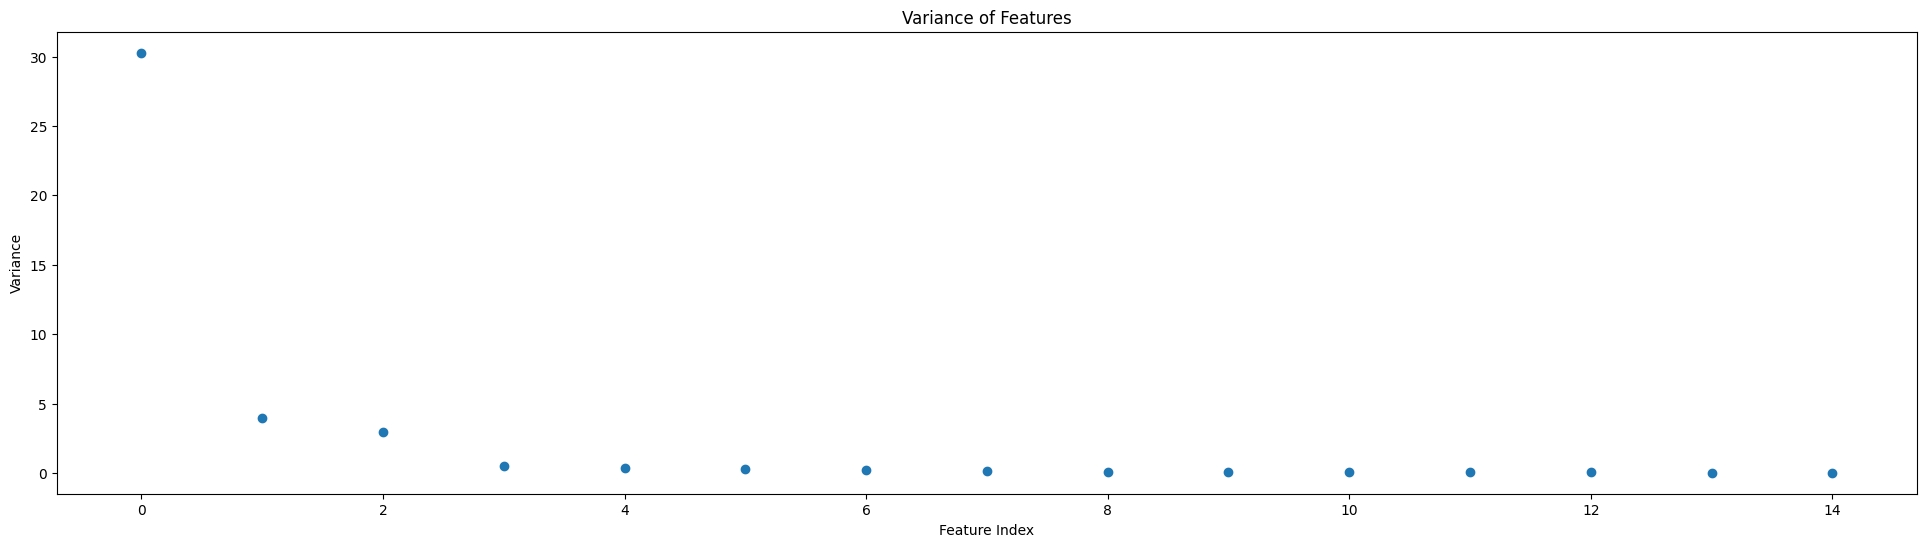

In [19]:
# Variance
plt.figure(figsize=(24, 6))
plt.plot(X_train_pca.var(axis=0), marker='o', linestyle='')
plt.title('Variance of Features')
plt.xlabel('Feature Index')
plt.ylabel('Variance')
plt.show()

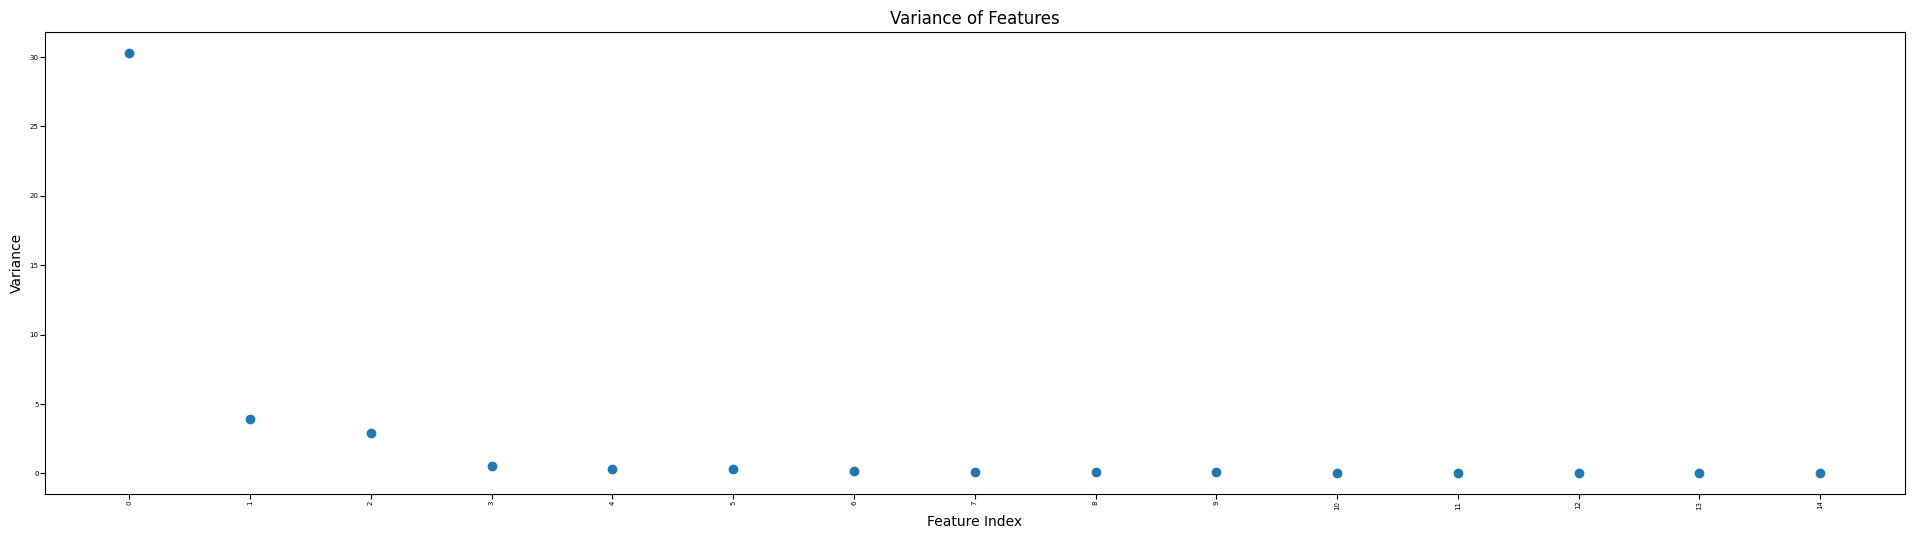

In [20]:
plt.figure(figsize=(24, 6))
plt.plot(X_train_pca.var(axis=0), marker='o', linestyle='')
plt.title('Variance of Features')
plt.xlabel('Feature Index')
plt.ylabel('Variance')

# Adjusting x-axis tick spacing and padding
num_features = X_train_pca.shape[1]
plt.xticks(ticks=range(num_features), labels=range(num_features), rotation=90, fontsize=5)
plt.gca().xaxis.set_tick_params(pad=1)

# Adjusting y-axis tick spacing and padding
plt.yticks(fontsize=5)
plt.gca().yaxis.set_tick_params(pad=1)
plt.show()

### RNN implementation


Best Accuracy: 0.37


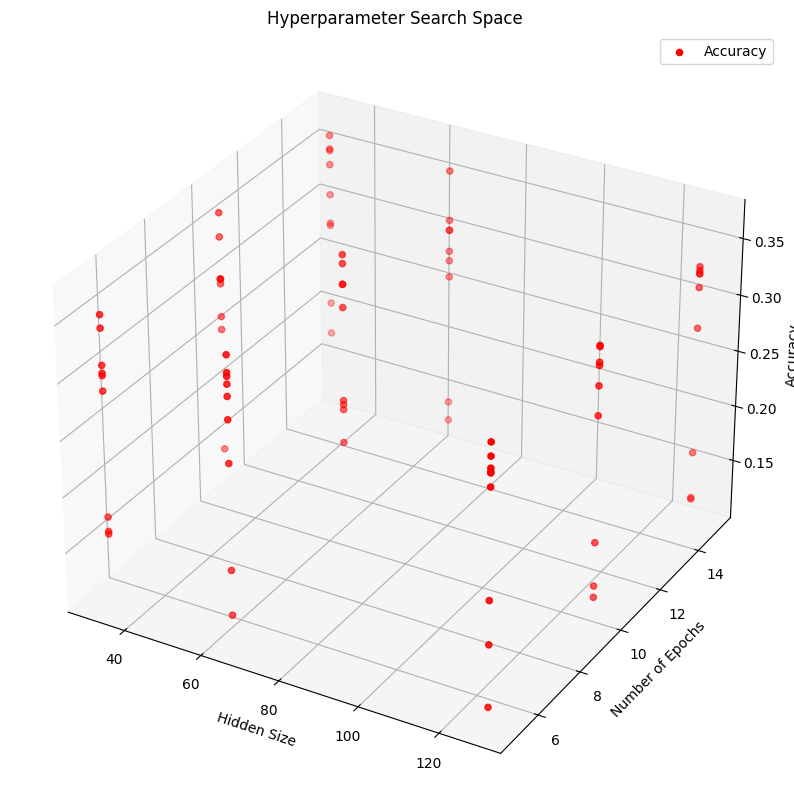

In [21]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        batch_size = x.size(0)
        seq_len = x.size(1)  # Get the sequence length
        h0 = torch.zeros(self.rnn.num_layers, self.hidden_size).to(x.device)

        out, _ = self.rnn(x, h0)
        return out


def train_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, hidden_size, num_epochs, learning_rate, batch_size):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    model = RNN(X_train_tensor.shape[1], hidden_size, len(label_encoder.classes_)).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.01) #weight_decay L2 norm

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    return model, accuracy


def evaluate_model(model, X_test_tensor, y_test_tensor):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    with torch.no_grad():
        X_test_tensor = X_test_tensor.to(device)
        y_test_tensor = y_test_tensor.to(device)
        outputs = model(X_test_tensor)
        _, predicted = torch.max(outputs.data, 1)
        accuracy = (predicted == y_test_tensor).sum().item() / y_test_tensor.size(0)

    return accuracy

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_encoded, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_encoded, dtype=torch.long)


# Define hyperparameter search space
hyperparameter_ranges = {
    'hidden_size': [32, 64, 128],
    'num_epochs': [5, 10, 15],
    'learning_rate': [0.0001, 0.001, 0.01],
    'batch_size': [16, 32, 64],
}

# Train model with different hyperparameter combinations
best_model = None
best_accuracy = 0.0

# Collect results
results = []

for hidden_size in hyperparameter_ranges['hidden_size']:
    for num_epochs in hyperparameter_ranges['num_epochs']:
        for learning_rate in hyperparameter_ranges['learning_rate']:
            for batch_size in hyperparameter_ranges['batch_size']:
                model, accuracy = train_model(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, hidden_size, num_epochs, learning_rate, batch_size)
                results.append((hidden_size, num_epochs, learning_rate, batch_size, accuracy))
                if accuracy > best_accuracy:
                    best_model = model
                    best_accuracy = accuracy

# Print best model performance
print(f'Best Accuracy: {best_accuracy:.2f}')

# Separate the results for plotting
hidden_sizes = [res[0] for res in results]
num_epochs = [res[1] for res in results]
learning_rates = [res[2] for res in results]
batch_sizes = [res[3] for res in results]
accuracies = [res[4] for res in results]

# Plotting
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(hidden_sizes, num_epochs, accuracies, c='r', marker='o', label='Accuracy')
ax.set_xlabel('Hidden Size')
ax.set_ylabel('Number of Epochs')
ax.set_zlabel('Accuracy')

plt.title('Hyperparameter Search Space')
plt.legend()
plt.show()